In [46]:
import numpy as np
import pandas as pd
from datetime import datetime
from functools import reduce
import matplotlib.pyplot as plt
from sklearn. model_selection import train_test_split
from sklearn. linear_model import LogisticRegression
from sklearn import metrics

In [5]:
#Подготовка данных
df_common = pd.read_csv('data/glo4.csv')
df_common['Дата продажи'] = pd.to_datetime(df_common['Дата продажи'])

C:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '22-01-2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '17-10-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '18-10-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\p

In [41]:
#Подготовка данных
df = df_common.groupby(['Клиент','Дата продажи'])['Сумма'].sum()
df = (pd.DataFrame(data = df)).reset_index()
#Отбросим все данные после даты актуальности()
df.sort_values(by = 'Дата продажи', ascending = True)
#преобразуем столбец с датами в индекс
df = df.set_index('Дата продажи')
#Для событий
df1_target = df['20190901':'20191001']
df2_target = df['20191001':'20191101']
#Прфиль 1
df1 = df[:'20190831']
df1 = df1.reset_index(level = 0)
#Профиль 2
df2 = df[:'20190930']
df2 = df2.reset_index(level = 0)

In [120]:
#Профиль клиента
def signa(df2, actual, target):
    #Давность
    df2_R = df2.sort_values(by = 'Дата продажи')\
    .drop_duplicates(['Клиент'], keep='last')\
    .sort_values(by = 'Клиент')
    df2_R['Дата актуальности'] = actual
    df2_R['Дата актуальности'] = pd.to_datetime(df2_R['Дата актуальности'])
    df2_R['Давность'] =(df2_R['Дата актуальности'] - df2_R['Дата продажи']) / np.timedelta64 ( 1 , 'D')
    df2_R.drop(['Сумма', 'Дата продажи', 'Дата актуальности'], axis='columns', inplace = True)

    #Частота 
    df2_F = pd.DataFrame(data = (df2.groupby('Клиент')['Дата продажи'].count()).reset_index(level = 0))
    df2_F['Частота'] = df2_F['Дата продажи']
    df2_F = df2_F.drop(['Дата продажи'], axis=1)

    #Деньги 
    df2_M = pd.DataFrame(data = (df2.groupby('Клиент')['Сумма'].sum()).reset_index(level = 0))

    #Процентная доля последней покупки от всех покупок
    df2_ML = pd.DataFrame(df2.groupby('Клиент')['Сумма'].agg(['sum','last']))
    df2_ML['Процентная доля'] = df2_ML['last']/df2_ML['sum']*100
    df2_ML = df2_ML.reset_index()
    df2_ML = df2_ML.drop(['last','sum'], axis=1)

    #Средняя частота визитов в месяц
    df2_FM = pd.DataFrame(data = (df2.groupby(['Клиент', pd.Grouper(key='Дата продажи', axis=0, freq='MS',
                                    label = 'right')])['Дата продажи']\
                                  .count())).reset_index(level = 0)
    df2_FM = pd.DataFrame(df2_FM.groupby('Клиент')['Дата продажи'].mean())
    df2_FM['Средняя частота визитов в месяц'] = df2_FM['Дата продажи']
    df2_FM = df2_FM.drop(['Дата продажи'], axis=1)
    
    #Доля выходных от всех визитов
    df_DW = df2
    df_DW['День недели'] = df_DW['Дата продажи'].dt.weekday
    df_DW['Выходной'] = df_DW['День недели'] > 4
    df_DW["Выходной"] = df_DW["Выходной"].astype(int)
    a = pd.DataFrame(df_DW.groupby('Клиент')['Выходной'].agg('sum'))
    b = pd.DataFrame(df_DW.groupby('Клиент')['Дата продажи'].agg('count'))
    w = (pd.DataFrame(a['Выходной']/b['Дата продажи']*100, columns = ['Доля выходных'])).reset_index()
    #Событие
    target['Событие'] = True
    final2_df = pd.merge(df2,target,on=['Клиент'],how='left')
    final2_df['Событие'].fillna(False, inplace=True)
    final2_df["Событие"] = final2_df["Событие"].astype(int)
    df2_y = final2_df.drop(['Дата продажи','Сумма_x','Сумма_y'], axis=1)
    df2_y = df2_y.groupby('Клиент')['Событие'].sum().reset_index(level = 0)
    df2_y['Событие'] = df2_y['Событие'] >= 1
    df2_y["Событие"] = df2_y["Событие"].astype(int)

    dfs2 = [df2_R, df2_F, df2_M, df2_FM, df2_ML,w, df2_y]
    sign2 = reduce(lambda left,right: pd.merge(left,right,on=['Клиент'],
                                                  how='inner'), dfs2)
    return sign2

In [42]:
sign1 = signa(df1,'2019-08-31', df1_target)
sign2 = signa(df2,'2019-09-30', df2_target)

In [117]:
sign1.corr(True)

ValueError: method must be either 'pearson', 'spearman', 'kendall', or a callable, 'True' was supplied

In [104]:
#Логистическая регрессия
X_train = sign1[['Давность','Частота','Сумма',
                 'Средняя частота визитов в месяц','Процентная доля','Доля выходных']]
y_train = sign1[['Событие']]
X_test = sign2[['Давность','Частота','Сумма',
                 'Средняя частота визитов в месяц','Процентная доля','Доля выходных']]
y_test = sign2[['Событие']]


In [105]:
X_test

Давность  Частота  Сумма  Средняя частота визитов в месяц  \
0         616.0        1   2273                         1.000000   
1         145.0        1   4757                         1.000000   
2          56.0        1   7299                         1.000000   
3          16.0       12  34081                         1.333333   
4         630.0        1   8495                         1.000000   
...         ...      ...    ...                              ...   
40967     310.0        2   3677                         1.000000   
40968     630.0        1   2499                         1.000000   
40969     117.0        2  17572                         1.000000   
40970       2.0       29  36174                         2.230769   
40971     239.0        3  13651                         1.000000   

       Процентная доля  Доля выходных  
0           100.000000       0.000000  
1           100.000000       0.000000  
2           100.000000       0.000000  
3            13.799478      41.666667  
4           100.000000       0.000000  
...                ...            ...  
40967        59.233070      50.000000  
40968       100.000000       0.000000  
40969        12.969497      50.000000  
40970         1.653121      31.034483  
40971        40.443924     100.000000  

[40972 rows x 6 columns]

In [106]:
log_regression = LogisticRegression()
log_regression.fit(X_train,y_train)
y_pred = log_regression.predict(X_test)

C:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [107]:
cnf_matrix = metrics.confusion_matrix (y_test, y_pred)
cnf_matrix

array([[31283,  1251],
       [ 6105,  2333]], dtype=int64)

In [108]:
print("Accuracy:", metrics. accuracy_score (y_test, y_pred))

 Accuracy: 0.8204627550522308


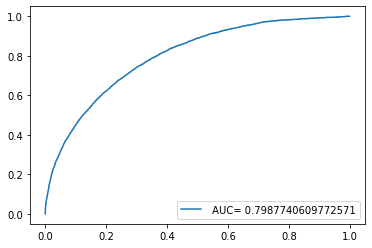

In [109]:
#define metrics
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.legend(loc=4)
plt.show()

In [110]:
print(log_regression.intercept_)
print(log_regression.coef_)

[-0.00219324]
[[-7.44956812e-03  3.09295108e-02 -9.30302193e-07 -4.67849175e-04
  -1.10793315e-02 -6.88401560e-03]]


In [111]:
y_pred_proba

array([0.00343358, 0.10300456, 0.18188462, ..., 0.21137736, 0.64867263,
       0.05522599])

In [112]:
y_pred_proba = pd.DataFrame(log_regression.predict_proba(X_test))

In [113]:
uu = X_test.join(y_pred_proba)

In [114]:
uu

Давность  Частота  Сумма  Средняя частота визитов в месяц  \
0         616.0        1   2273                         1.000000   
1         145.0        1   4757                         1.000000   
2          56.0        1   7299                         1.000000   
3          16.0       12  34081                         1.333333   
4         630.0        1   8495                         1.000000   
...         ...      ...    ...                              ...   
40967     310.0        2   3677                         1.000000   
40968     630.0        1   2499                         1.000000   
40969     117.0        2  17572                         1.000000   
40970       2.0       29  36174                         2.230769   
40971     239.0        3  13651                         1.000000   

       Процентная доля  Доля выходных         0         1  
0           100.000000       0.000000  0.996566  0.003434  
1           100.000000       0.000000  0.896995  0.103005  
2           100.000000       0.000000  0.818115  0.181885  
3            13.799478      41.666667  0.555343  0.444657  
4           100.000000       0.000000  0.996923  0.003077  
...                ...            ...       ...       ...  
40967        59.233070      50.000000  0.962818  0.037182  
40968       100.000000       0.000000  0.996906  0.003094  
40969        12.969497      50.000000  0.788623  0.211377  
40970         1.653121      31.034483  0.351327  0.648673  
40971        40.443924     100.000000  0.944774  0.055226  

[40972 rows x 8 columns]